# PART A: Predictive Models

In [ ]:
!pip install transformers
import random
import os
random.seed(42)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.4 MB/s eta 0:00:00


In [ ]:
# Load our data from the adjudicated-2.txt file into df
df = pd.read_csv("adjudicated-2.txt", sep="\t", names=["label", "text"])

In [ ]:
# read in our data
with open("adjudicated-2.txt", "r") as f:
    data = f.readlines()

# shuffle data
random.shuffle(data)
num_data = len(data)
num_train = int(num_data * 0.6)
num_dev = int(num_data * 0.2)
num_test = num_data - num_train - num_dev
# train/dev/test data
train_data = data[:num_train]
dev_data = data[num_train:num_train+num_dev]
test_data = data[num_train+num_dev:]
if not os.path.exists("splits"):
    os.makedirs("splits")
# Write the data to the corresponding split files
with open("splits/train.txt", "w") as f:
    f.writelines(train_data)
with open("splits/dev.txt", "w") as f:
    f.writelines(dev_data)
with open("splits/test.txt", "w") as f:
    f.writelines(test_data)


In [ ]:
import pandas as pd

def spoiler_feature(text):
    spoiler_keywords = ['spoiler', 'reveals', 'ending', 'twist', 'revealed', 'plot', 'secret', 'dies', 'palpatine']
    count = 0
    
    for keyword in spoiler_keywords:
        count += text.lower().count(keyword)
        
    return count

# Apply the function to create a new feature column
df['spoiler_feature'] = df['text'].apply(spoiler_feature)

print(df)

                 label                                               text  \
0   adjudicated      3  Batman Begins is the best batman film made so ...   
1   adjudicated      3  Batman is all about a man who battles his enem...   
2   adjudicated      3  Batman was created by Bob Kane in 1939 and in ...   
3   adjudicated      3  A new movie and an excellent start to the Batm...   
4   adjudicated      1  A young Bruce Wayne watches in horror, as his ...   
...                ...                                                ...   
495 adjudicated      3  What a waste of resources. This subject- less,...   
496 adjudicated      3  When did Star Wars become Micheal Bay's Transf...   
497 adjudicated      3  Words cannot describe the disgust that is this...   
498 adjudicated      3  Wow, I can't even believe I'm writing this. I ...   
499 adjudicated      1  You probably read this before, but Palpatine i...   

                 spoiler_feature  
0   adjudicated                0  
1   a

In [ ]:
# splitting data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)
# BOW Logistic Regression
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df["text"])
X_val = vectorizer.transform(val_df["text"])
X_test = vectorizer.transform(test_df["text"])
# log reg model on the bag of words features
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, train_df["label"])

# evaluate the model on the val set
val_preds = lr_model.predict(X_val)
val_acc = accuracy_score(val_df["label"], val_preds)
val_f1 = f1_score(val_df["label"], val_preds, average="weighted")
print("Bag of Words Logistic Regression val Accuracy:", val_acc)
print("Bag of Words Logistic Regression val F1 Score:", val_f1)


test_preds = lr_model.predict(X_test)
test_acc = accuracy_score(test_df["label"], test_preds)
test_f1 = f1_score(test_df["label"], test_preds, average="weighted")
print("Bag of Words Logistic Regression Test Accuracy:", test_acc)
print("Bag of Words Logistic Regression Test F1 Score:", test_f1)

# Baseline model 2: Ordinal Regression

enc = OrdinalEncoder(categories=[["1", "2", "3"]])
train_labels = enc.fit_transform(train_df[["label"]]).ravel()
val_labels = enc.transform(val_df[["label"]]).ravel()
test_labels = enc.transform(test_df[["label"]]).ravel()

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, train_labels)

val_preds = enc.inverse_transform(lr_model.predict(X_val).reshape(-1, 1)).ravel()
val_acc = accuracy_score(val_df["label"], val_preds)
val_f1 = f1_score(val_df["label"], val_preds, average="weighted")
print("Ordinal Regression val Accuracy:", val_acc)
print("Ordinal Regression val F1 Score:", val_f1)

test_preds = enc.inverse_transform(lr_model.predict(X_test).reshape(-1, 1)).ravel()
test_acc = accuracy_score(test_df["label"], test_preds)
test_f1 = f1_score(test_df["label"], test_preds, average="weighted")
print("Ordinal Regression Test Accuracy:", test_acc)
print("Ordinal Regression Test F1 Score:", test_f1)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Bag of Words Logistic Regression val Accuracy: 0.87
Bag of Words Logistic Regression val F1 Score: 0.8490187265917604
Bag of Words Logistic Regression Test Accuracy: 0.9
Bag of Words Logistic Regression Test F1 Score: 0.8827070707070707
Ordinal Regression val Accuracy: 0.87
Ordinal Regression val F1 Score: 0.8490187265917604
Ordinal Regression Test Accuracy: 0.9
Ordinal Regression Test F1 Score: 0.8827070707070707


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
import nltk
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def spoiler_feature(text):
    spoiler_keywords = ['spoiler', 'reveals', 'ending', 'twist', 'revealed', 'plot', 'secret', 'killed', 
                        'dies', 'palpatine', 'voldemort', "ending", "shocked", "surprising", "switch"]
    count = 0
    
    for keyword in spoiler_keywords:
        count += text.lower().count(keyword)
        
    return count

def featurize(text):
    features = {}
    words = text.split()

    #common sentence phrases 
  
    features['spoiler_keywords_count'] = spoiler_feature(text)
    return features

features = df['text'].apply(featurize).tolist()
vectorizer = DictVectorizer()
X = vectorizer.fit_transform(features)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.75      0.27      0.40        11
           2       0.00      0.00      0.00         5
           3       0.87      0.99      0.93        84

    accuracy                           0.86       100
   macro avg       0.54      0.42      0.44       100
weighted avg       0.82      0.86      0.82       100

[[ 3  1  7]
 [ 0  0  5]
 [ 1  0 83]]


# Our data is very unbalanced and so our model is overfitting.We can attempt to perform techniques that help to balance out our data such as:
*   Ensure our dataset is balanced or apply techniques like oversampling or undersampling
*   Experiment with different features or feature engineering techniques
* Use other models (other than random forest) or ensemble methods to improve prediction accuracy
* Perform hyperparameter tuning to optimize the model's performance 



In [ ]:
!pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

# Oversample the minority classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.85      0.39      0.53        88
           2       0.52      0.49      0.50        82
           3       0.54      0.87      0.67        87

    accuracy                           0.58       257
   macro avg       0.64      0.58      0.57       257
weighted avg       0.64      0.58      0.57       257

[[34 27 27]
 [ 5 40 37]
 [ 1 10 76]]


In [ ]:
# Baseline model 3: Majority Class Classifier
# Determine the majority class
majority_class = train_df["label"].mode().values[0]

# Evaluate the model on the val set
val_preds = [majority_class] * len(val_df)
val_acc = accuracy_score(val_df["label"], val_preds)
val_f1 = f1_score(val_df["label"], val_preds, average="weighted")
print("Maj Classifier val Acc:", val_acc)
print("MajClassifier Val F1 Score:", val_f1)

# Evaluate the model on the test set
test_preds = [majority_class] * len(test_df)
test_acc = accuracy_score(test_df["label"], test_preds)
test_f1 = f1_score(test_df["label"], test_preds, average="weighted")
print("Maj Classifier Test Acc:", test_acc)
print("Maj class Test F1 Score:", test_f1)

Maj Classifier val Acc: 0.86
MajClassifier Val F1 Score: 0.7952688172043011
Maj Classifier Test Acc: 0.84
Maj class Test F1 Score: 0.7669565217391304


# PART B: Evaluating our models

Our data is very unbalanced and so our model is overfitting. We can attempt to perform techniques that help to balance out our data such as:
Ensure our dataset is balanced or apply techniques like oversampling or undersampling
Experiment with different features or feature engineering techniques
Use other models (other than random forest) or ensemble methods to improve prediction accuracy
Perform hyperparameter tuning to optimize the model's performance

**Think about the level of balance in your dataset: Is one label extremely prevalent? How could this impact the model you developed? Is your dataset a good candidate for strategies like oversamplingLinks to an external site. or changing class weightsLinks to an external site.?** 

**Answer:** Our dataset is *very* unbalanced. So we are dealing with an unbalanced multiclass classification problem. ~80% of our data is classified as a 3, or meaning "No Spoilers" for our movie reviews. 

We attempted to do oversampling to see if this would help improve our overfitting but it actually made it worse. This led us to do analysis on feature importance and see if feature selection would improve our overfitting as well. 

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import RandomUnderSampler

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])
y = df['label']

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

balanced_labels = pd.Series(y_resampled)
print(balanced_labels.value_counts())

1    34
2    34
3    34
Name: label, dtype: int64


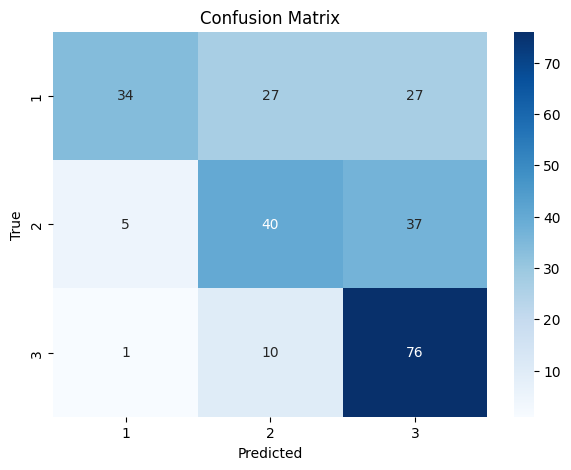

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


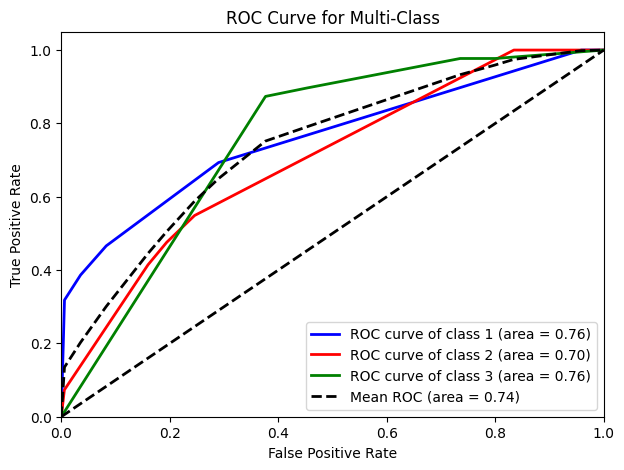

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])
y_pred_proba = clf.predict_proba(X_test)
n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

mean_auc = auc(all_fpr, mean_tpr)
plt.figure(figsize=(7, 5))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i+1} (area = {roc_auc[i]:.2f})')

plt.plot(all_fpr, mean_tpr, color='black', lw=2, linestyle='--', label=f'Mean ROC (area = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class')
plt.legend(loc='lower right')
plt.show()
